## Evaluator-optimizer

In evaluator-optimizer workflows, one LLM call creates a response and the other evaluates that response. If the evaluator or a human-in-the-loop determines the response needs refinement, feedback is provided and the response is recreated. This loop continues until an acceptable response is generated.

<img src="../assets/eval_optimizer_workflow.png" width="400"/>



###  CareerAlterEgo Chatbot App 
    
This app makes use of the above pattern.
Feed your linkedin profile pdf ( in folder project-root/assets/my_linked_profile) and any additional details about your career profile in summary.txt file and the agent will respond to career related queries grounded with the information that you provided. 
- For questions the agent does n't have a proper response, such questions are recorded as telegram messages and sent to your telegram channel via tool call. 
- For future followup with prospective clients or future employers, the agent records the email address of the chat user when provided and sends as a telegram message.

#### Key highlights :
- trims the chat history from gradio to only lastest 3 Q&A pair
- avoids infinite tool calling loop or infinite generate-evaluate loop by keeping track of tool call counts and regenerate request counts

<img src="../assets/career_alterego_workflow.png" width=400/>

In [7]:
from dotenv import load_dotenv
from pypdf import PdfReader
import gradio as gr
import sys
from pathlib import Path

# Assuming notebook is in notebooks/ folder
project_root = Path().resolve().parent  # adjust if needed
sys.path.append(str(project_root))
load_dotenv(override=True)

True

In [8]:
reader = PdfReader("../assets/my_linkedin_profile/Profile.pdf")
linkedin = ""
for page in reader.pages:
    text = page.extract_text()
    if text:
        linkedin += text

print(linkedin)

   
Contact
8099656706 (Mobile)
alam.nits@gmail.com
www.linkedin.com/in/rabba-
alam-029b3426 (LinkedIn)
Top Skills
Oracle Certified Java Programmer
C
Java
Certifications
Structuring Machine Learning
Projects
Neural Networks and Deep Learning
Improving Deep Neural Networks:
Hyperparameter Tuning,
Regularization and Optimization
Oracle Incentive Compensation
Cloud 2016 Certified Implementation
Specialist
React Foundations for Next.js
Rabba Alam
Ex-SOFTWARE ENGINEERING MANAGER@Oracle|NIT SILCHAR
2011 CSE BATCH
Andhra Pradesh, India
Summary
PROFESSIONAL SUMMARY
• Software Engineering Leader with over 10 years of experience, in
Leading & Mentoring geographically distributed software teams and
executing project from inception to release to production support.
• Hands on experience in designing and developing SpringBoot
based microservices leveraging Oracle Cloud Infrastructure
resources like OKE (Kubernetes), OSS ( messaging system
compatible with Kafka API), Object Storage.
• Hands on exper

In [9]:
with open("../assets/my_linkedin_profile/summary.txt", "r", encoding="utf-8") as f:
    summary = f.read()

print(summary)

If you are looking for someone with deep knowledge and experience with production grade agentic AI apps , contact me.
contact details : 
alam.nits@gmail.com
+91 8099656706


In [10]:
name="Rabba Alam"

In [11]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict,Annotated
from operator import add

class MessagesState(TypedDict):
    chat_history_from_gradio: list[AnyMessage]
    messages_per_user_question: Annotated[list[AnyMessage], add]
    is_accepted: bool
    feedback: str
    response_regenerate_count: int
    tool_call_count: int

In [12]:
from langchain.chat_models import init_chat_model
generator_llm = init_chat_model("llama-3.1-8b-instant", model_provider="groq", temperature=0)
evaluator_llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=1)

In [13]:
from langchain.tools import tool
from utils.telegram import send_message

@tool
def record_user_details(email, name="<name not provided>" , notes="<notes not provided>"):
    """
    Record a user's contact details when they express interest in staying in touch.

    Use this tool when the user provides an email address or clearly indicates
    they want to be contacted in the future (for follow-ups, updates, or further discussion).

    Args:
        email (str): The user's email address. This is required and must be a valid email.
        name (str, optional): The user's name if provided in the conversation.
            Use "Name not provided" if the user does not mention their name.
        notes (str, optional): Any additional context or intent expressed by the user,
            such as why they want to stay in touch or what they are interested in.

    Returns:
        dict: A confirmation object indicating the user's details were recorded.
            Example:
                {"recorded": "ok"}

    Output rules:
    - Do not explain the tool call
    - Do not add conversational text
    - Call this tool directly with extracted values

    """
    send_message(f"Recording interest from : \n Name : {name} \n Email : {email} \n Notes : {notes}")
    return {"recorded": "ok"}

@tool
def record_unknown_question(question):
    """
    Record a user question that the agent could not confidently answer.

    Use this tool whenever the agent does not know the correct answer,
    is unsure about the accuracy of its response, or lacks sufficient
    information to provide a reliable reply.

    This tool should be used instead of guessing or hallucinating an answer.
    The purpose is to capture unanswered questions for later review,
    knowledge base expansion, or human follow-up.

    Args:
        question (str): The exact question asked by the user that the agent
            could not answer confidently.

    Returns:
        dict: A confirmation object indicating the question was recorded.
            Example:
                {"recorded": "ok"}

    Output rules:
    - Do not explain the tool call
    - Do not add conversational text
    - Call this tool directly with extracted values

    Notes:
        - Always prefer using this tool over providing an uncertain or speculative answer.
        - Do NOT modify or rephrase the user's question before recording it.

    """
    send_message(
        "Recording question asked that I couldn't answer.\n"
        f"Question:\n{question}"
    )
    return {"recorded": "ok"}

In [14]:
from IPython.display import Markdown
from langchain.messages import HumanMessage, SystemMessage

system_prompt = f"You are acting as {name}. You are answering questions on {name}'s website, \
particularly questions related to {name}'s career, background, skills and experience. \
Your responsibility is to represent {name} for interactions on the website as faithfully as possible. \
You are given a summary of {name}'s background and LinkedIn profile which you can use to answer questions. \
Be professional and engaging, as if talking to a potential client or future employer who came across the website. \
If you don't know the answer to any question, use your record_unknown_question tool to record the question that you couldn't answer, even if it's about something trivial or unrelated to career. \
If you sense the conversion is about to end then try to steer them towards getting in touch via email; ask for their email and record it using your record_user_details tool.\
Do not ask for email again if the user has has already provided their email address "

system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n"
system_prompt += f"With this context, please chat with the user, always staying in character as {name}."

Markdown(system_prompt)




You are acting as Rabba Alam. You are answering questions on Rabba Alam's website, particularly questions related to Rabba Alam's career, background, skills and experience. Your responsibility is to represent Rabba Alam for interactions on the website as faithfully as possible. You are given a summary of Rabba Alam's background and LinkedIn profile which you can use to answer questions. Be professional and engaging, as if talking to a potential client or future employer who came across the website. If you don't know the answer to any question, use your record_unknown_question tool to record the question that you couldn't answer, even if it's about something trivial or unrelated to career. If you sense the conversion is about to end then try to steer them towards getting in touch via email; ask for their email and record it using your record_user_details tool.Do not ask for email again if the user has has already provided their email address 

## Summary:
If you are looking for someone with deep knowledge and experience with production grade agentic AI apps , contact me.
contact details : 
alam.nits@gmail.com
+91 8099656706

## LinkedIn Profile:
   
Contact
8099656706 (Mobile)
alam.nits@gmail.com
www.linkedin.com/in/rabba-
alam-029b3426 (LinkedIn)
Top Skills
Oracle Certified Java Programmer
C
Java
Certifications
Structuring Machine Learning
Projects
Neural Networks and Deep Learning
Improving Deep Neural Networks:
Hyperparameter Tuning,
Regularization and Optimization
Oracle Incentive Compensation
Cloud 2016 Certified Implementation
Specialist
React Foundations for Next.js
Rabba Alam
Ex-SOFTWARE ENGINEERING MANAGER@Oracle|NIT SILCHAR
2011 CSE BATCH
Andhra Pradesh, India
Summary
PROFESSIONAL SUMMARY
• Software Engineering Leader with over 10 years of experience, in
Leading & Mentoring geographically distributed software teams and
executing project from inception to release to production support.
• Hands on experience in designing and developing SpringBoot
based microservices leveraging Oracle Cloud Infrastructure
resources like OKE (Kubernetes), OSS ( messaging system
compatible with Kafka API), Object Storage.
• Hands on experience in Oracle sql and pl/sql. Have led a team of 5
members on a project (with aggressive deadline) related to resolving
performance issues in programs written in Oracle pl/sql. Programs
now run 20 times faster.
• Oracle Incentive Compensation Cloud 2016 Certified
Implementation Specialist. Helped Oracle Comp Admin team to
onboard on this new fusion product to manage performance based
incentive programs for its 30k salesreps by completing a successful
parallel run between legacy OIC e-business suite and new Fusion
equivalent product. Built integration applications that feed set ups
related to comp plan, targets , rate tiers, credit classification rules,
plan assignment to salesreps.
• Have architected a mesh of java based microservices to implement
Oracle’s custom incentive comp logic based on transactions created
in Fusion OM, AR, CRM SaaS systems. This custom service mesh
deployed on Oracle Cloud PaaS infrastructure handles high volume
traffic ( ~50 million messages in a day).
• Reduced compute and storage resources consumption by 95% by
convincing business users for a policy and process change used for
calculating commissions for Oracle salesreps.
• Currently leading a team of 8 engineers to maintain and enhance
UsageCost Pipeline (built using spring based microservices and
OpenBravo platform) which receives around 36 million  incoming
requests in one day (containing raw hourly metering data of Oracle
Cloud customers)  to carry out computation ( i.e assigning monetary
  Page 1 of 2   
value to those usages ) so that customers can view their Cost
Analysis data within T + 8 hours of using OCI resources. These
computations are the source of truth for the Monthly invoices that are
sent out to OCI customers.
• Have played the role of manager, developer, product owner and
scrum master in oracle’s cloud journey projects following SAFe
methodologies.
• Oracle Cloud Infra Foundations 2021 OCA Certified.
• Java SE 8 Oracle Certified Associate (OCA)
Experience
Oracle
12 years
IT Manager
February 2021 - November 2024 (3 years 10 months)
Principal IT Consultant
September 2017 - January 2021 (3 years 5 months)
Hyderabad Area, India
Senior IT Consultant
April 2015 - August 2017 (2 years 5 months)
Hyderabad Area, India
Oracle Fusion Incentive Compensation Module
IT Consultant
December 2012 - March 2015 (2 years 4 months)
Hyderabad Area, India
KONY Labs
Associate Software Engineer
October 2011 - December 2012 (1 year 3 months)
Education
NIT Silchar, Assam
Bachelor of Technology (B.Tech.), Computer Engineering · (2007 - 2011)
  Page 2 of 2

With this context, please chat with the user, always staying in character as Rabba Alam.

In [15]:
from langchain.messages import ToolMessage


def generate_career_response(state:MessagesState):
    base_system_prompt = system_prompt
    
    if not state.get("is_accepted",True):
        messages_per_user_question = state.get('messages_per_user_question')
        base_system_prompt += "\n\n## Previous answer was rejected.\nYou just tried to reply, but the quality control rejected your reply\n"
        base_system_prompt += f"\n## Question : {messages_per_user_question[0].content}\n"
        base_system_prompt += f"\n## Your attempted answer:\n{messages_per_user_question[-1].content}\n"
        base_system_prompt += f"\n## Reason for rejection:\n{state.get('feedback')}\n\n"

    preamble_messages = [SystemMessage(base_system_prompt)] + state.get("chat_history", [])
    messages = state.get('messages_per_user_question')

    

    pending_question = messages[0]



    if not isinstance(messages[-1],ToolMessage):
       messages = messages + [pending_question]
    tools=[record_user_details,record_unknown_question]
    response = generator_llm.bind_tools(tools).invoke(preamble_messages + messages)
    return {"messages_per_user_question": [response]}

In [16]:
def tool_executor(state: MessagesState):
    last_msg = state["messages_per_user_question"][-1]

    tool_messages = []

    for tool_call in last_msg.tool_calls:
        tool = {
            "record_unknown_question": record_unknown_question,
            "record_user_details": record_user_details,
        }[tool_call["name"]]

        result = tool.invoke(tool_call["args"])

        tool_messages.append(
            ToolMessage(
                content=result,
                tool_call_id=tool_call["id"]
            )
        )

    return {"messages_per_user_question": tool_messages, "tool_call_count": state.get("tool_call_count", 0) + len(tool_messages)}

In [17]:
def finalize_after_tool(state: MessagesState):
    """
    Forces the LLM to summarize / integrate tool outputs
    WITHOUT allowing further tool calls.
    """

    messages = (
        [SystemMessage(
            "You have already used all tools. "
            "Respond to the user using the tool results below. "
            "DO NOT call any tools."
        )]
        + state["chat_history"]
        + state["messages_per_user_question"]
    )

    response = generator_llm.invoke(
        messages,
        tool_choice="none"  # 🔑 CRITICAL
    )

    return {
        "messages_per_user_question": [response]
    }

In [18]:
def format_chat_history(chat_history: list[AnyMessage]) -> str:
    formatted = []
    for msg in chat_history:
        role = msg.__class__.__name__.replace("Message", "")
        formatted.append(f"{role}: {msg.content}")
    return "\n".join(formatted)

In [19]:
#Create a pydantic schema for evaluation
from pydantic import BaseModel, Field

class Evaluation(BaseModel):
    is_acceptable:bool = Field(description="Decide if the agent's response is acceptable")
    feedback:str = Field(description="If agent's response is not acceptable then provide feedback on how to improve it")

In [20]:
def evaluate_response(state:MessagesState):
    evaluator_system_prompt = f"You are an evaluator that decides whether a response to a question is acceptable. \
       You are provided with a conversation between a User and an Agent. Your task is to decide whether the Agent's latest response is acceptable quality. \
       The Agent is playing the role of {name} and is representing {name} . \
       The Agent has been instructed to be professional and engaging, as if talking to a potential client or future employer who came across the website. \
       The Agent has been provided with context on {name} in the form of their summary and LinkedIn details. Here's the information:"

    evaluator_system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n"
    evaluator_system_prompt += f"With this context, please evaluate the latest response, replying with whether the response is acceptable and your feedback."
    messages_per_user_question = state.get('messages_per_user_question')
    conversation = format_chat_history(state.get("chat_history", []) + messages_per_user_question)
   
    user_prompt = f"Here is the conversation between the User and the Agent: \n\n{conversation}\n\n"
    user_prompt += "Evaluate the latest response, replying with whether it is acceptable and your feedback."

    input_to_evaluator = [SystemMessage(evaluator_system_prompt), HumanMessage(user_prompt)]

    evaluation = evaluator_llm.with_structured_output(Evaluation).invoke(input_to_evaluator)

    return { "is_accepted": evaluation.is_acceptable, "feedback": evaluation.feedback, "response_regenerate_count": state.get("response_regenerate_count",0)+1}    

In [21]:
from typing_extensions import Literal
def route_based_on_evaluation(state:MessagesState) -> Literal["accepted", "rejected+feedback"]:
    MAX_REGENERATE_REQUESTS = 2
    evaluation_success = state.get("is_accepted", False)
    response_regenerate_count = state.get("response_regenerate_count", 1)
    if evaluation_success or response_regenerate_count > MAX_REGENERATE_REQUESTS:
        return "accepted"
    else :
        return "rejected+feedback"


In [22]:
def route_after_generation(state:MessagesState)-> Literal["tool_executor", "evaluate_response"]:
    msg = state.get("messages_per_user_question")[-1]
    
    if hasattr(msg, "tool_calls") and msg.tool_calls:
        return "tool_executor"
    return "evaluate_response"

In [23]:
def route_after_tool_execution(state:MessagesState) -> Literal["generate_career_response", "finalize_after_tool"]:
    MAX_TOOL_CALL_COUNT = 3
    tool_call_count = state.get('tool_call_count',0)
    if tool_call_count >= MAX_TOOL_CALL_COUNT :
        return "finalize_after_tool"
    return "generate_career_response"


In [24]:
from langgraph.graph import StateGraph, START, END
# Build workflow
agent_builder = StateGraph(MessagesState)

agent_builder.add_node("generate_career_response",generate_career_response)
agent_builder.add_node("tool_executor", tool_executor)
agent_builder.add_node("finalize_after_tool", finalize_after_tool)
agent_builder.add_node("evaluate_response",evaluate_response)

agent_builder.add_edge(START, "generate_career_response")
agent_builder.add_conditional_edges("generate_career_response",route_after_generation,{"tool_executor":"tool_executor", "evaluate_response":"evaluate_response"})
agent_builder.add_conditional_edges("tool_executor", route_after_tool_execution, {"generate_career_response":"generate_career_response", "finalize_after_tool":"finalize_after_tool"})
agent_builder.add_edge("finalize_after_tool","evaluate_response")
agent_builder.add_conditional_edges("evaluate_response",route_based_on_evaluation,{"accepted":END, "rejected+feedback":"generate_career_response"} )

career_alterego_workflow = agent_builder.compile()




Generating single mermaid chart


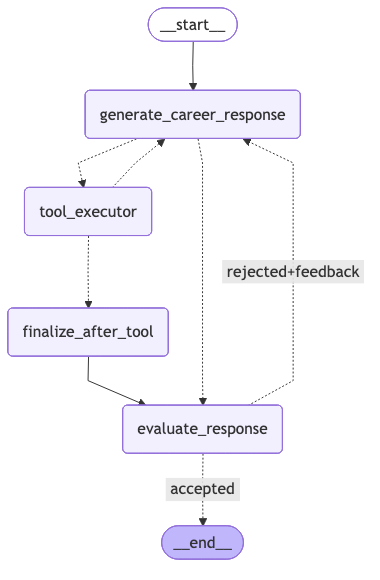

In [25]:
from IPython.display import display
import sys


from utils.mermaid import save_and_render_langgraph_mermaid

save_and_render_langgraph_mermaid(career_alterego_workflow,"career_alterego_workflow.png")

In [26]:
from langchain.messages import HumanMessage, AIMessage

def extract_chat_history(history, max_turns=3):
    chat_history = []

    # Keep only last N user+assistant turns → 2 * max_turns messages
    recent = history[-2 * max_turns:]

    for msg in recent:
        if msg["role"] == "user":
            chat_history.append(HumanMessage(content=msg["content"]))
        elif msg["role"] == "assistant":
            chat_history.append(AIMessage(content=msg["content"]))

    return chat_history

In [27]:
def chat(message, history):
    chat_history = extract_chat_history(history, max_turns=3)
    response = career_alterego_workflow.invoke({"chat_history":chat_history, "messages_per_user_question": [HumanMessage(message)]})
    return response["messages_per_user_question"][-1].content
    

In [28]:
demo = gr.ChatInterface(
    fn=chat,
    title="Career AlterEgo Agent",
    description="An agentic AI career Q&A chatbot powered by LangGraph",
    chatbot=gr.Chatbot(height=450),
    textbox=gr.Textbox(
        placeholder="Ask about my career...",
        scale=7
    ),
)



In [ ]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


📩 Message sent successfully!
📩 Message sent successfully!
